<a href="https://colab.research.google.com/github/MariaZharova/3-day-intensive/blob/main/mipt_int_recsys/%D0%98%D0%BD%D1%82%D0%B5%D0%BD%D1%81%D0%B8%D0%B2_RecSys_%D0%94%D0%B5%D0%BD%D1%8C_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интенсив "Пишем рекомендательную систему как в YouTube (почти)"
## День 3
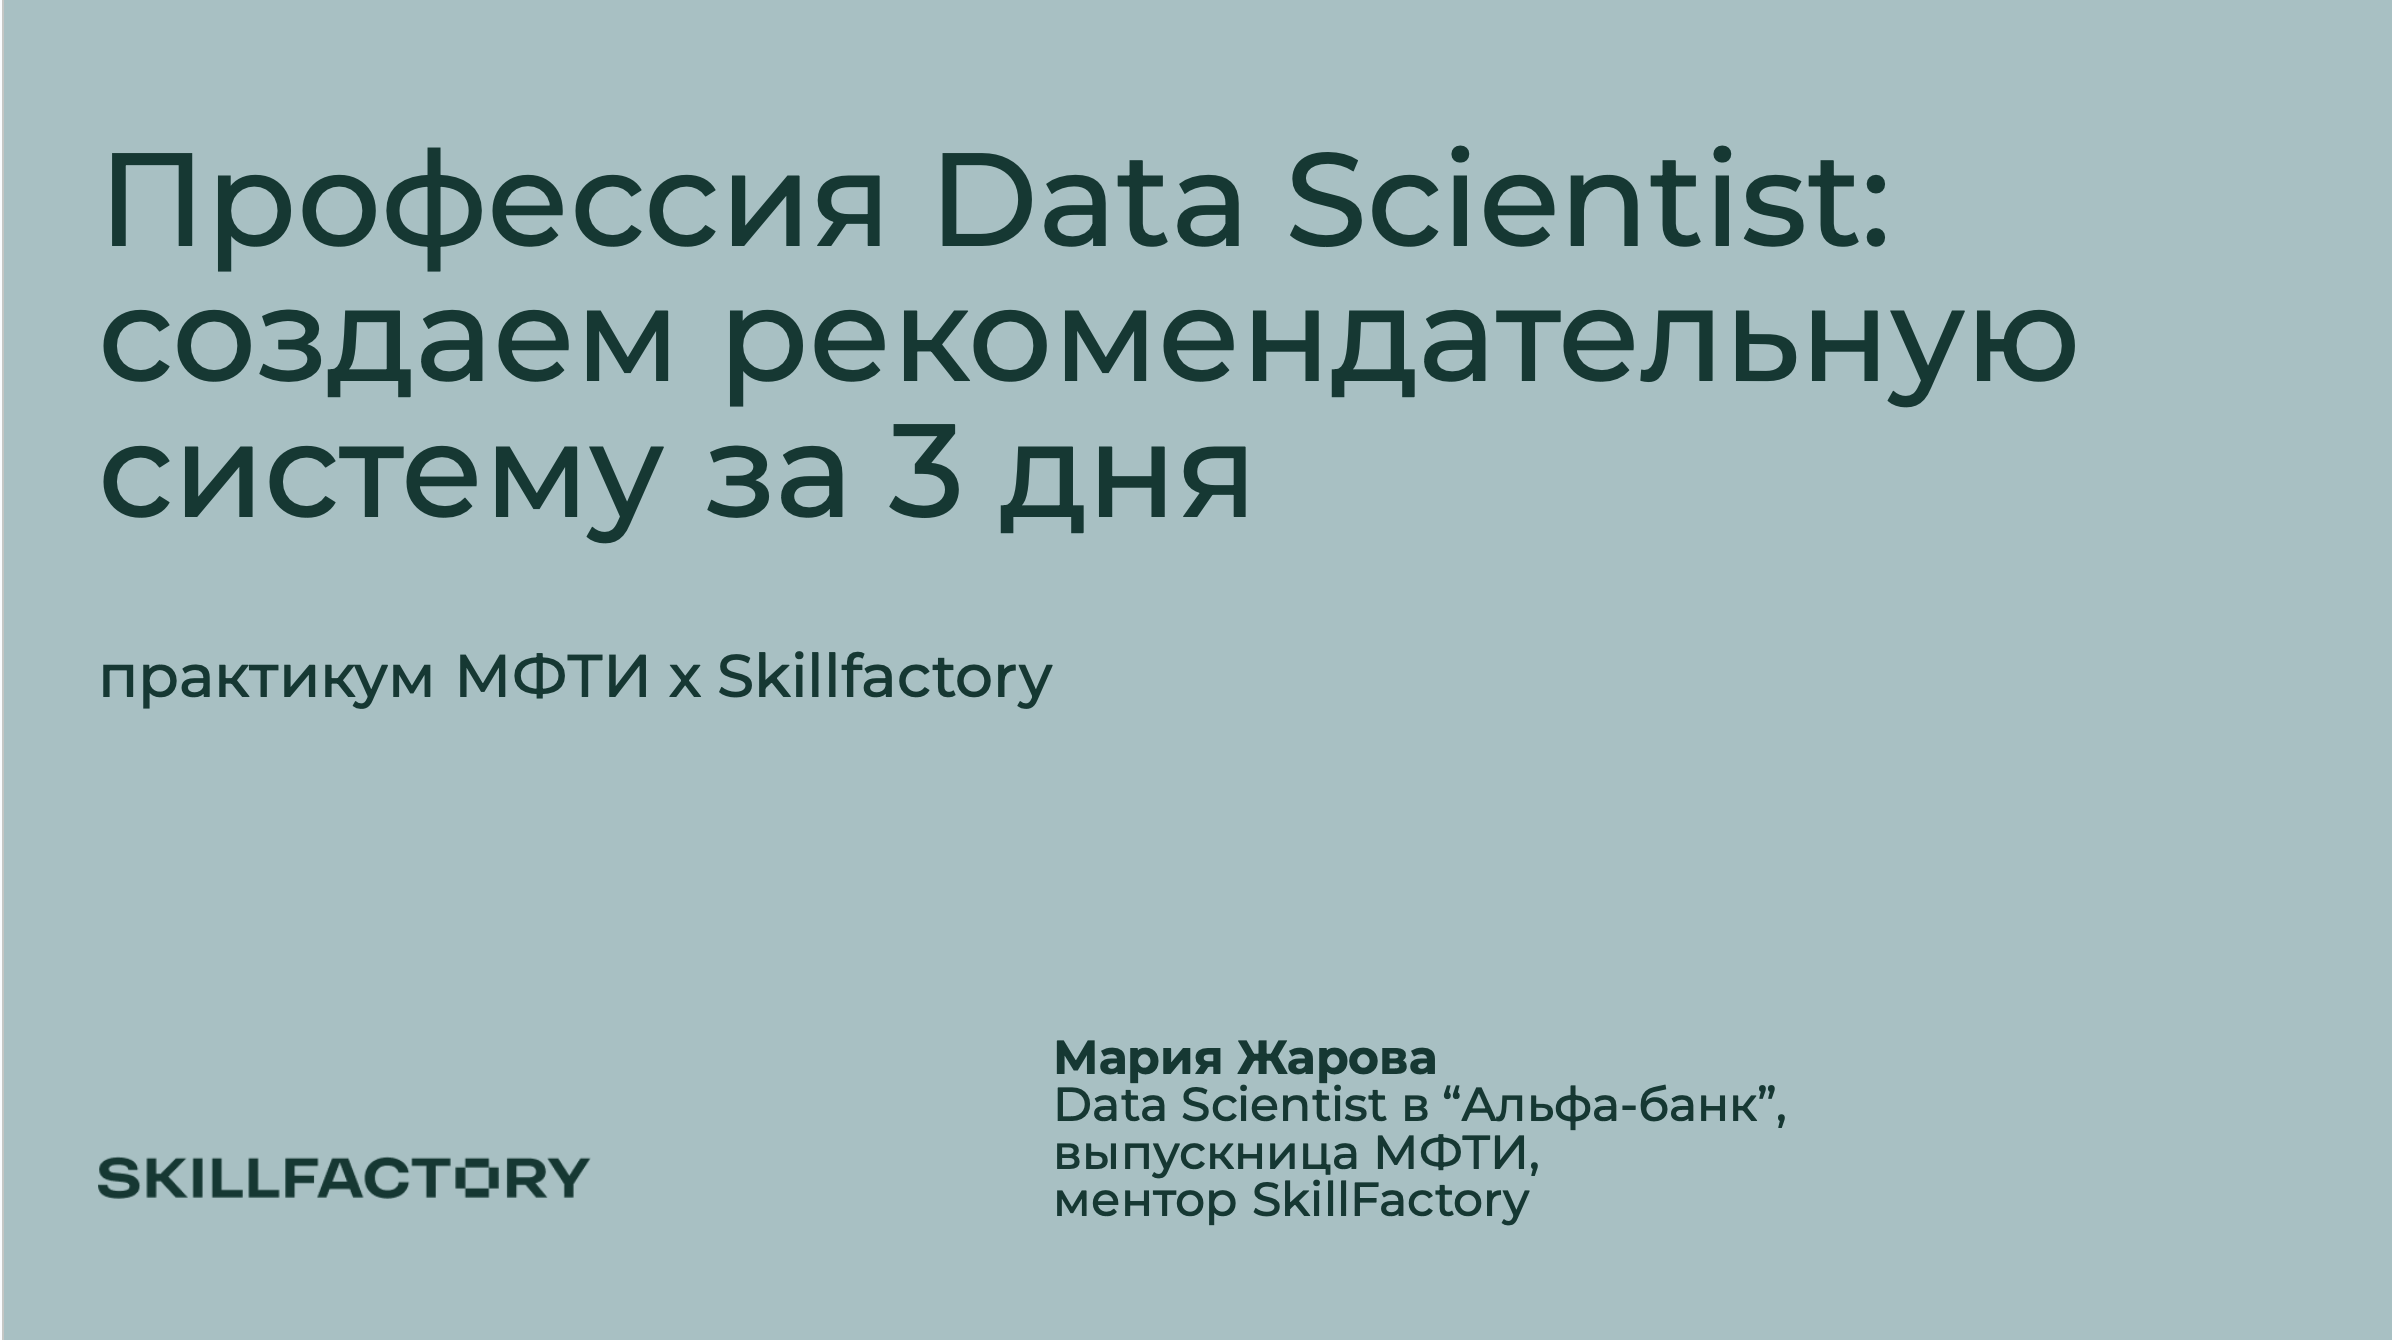

### Загрузим и обработаем текстовые данные, как вчера

In [1]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/MariaZharova/3-day-intensive/main/mipt_int_recsys/video_dataset.csv")
data_small = data.loc[:, ['id', 'title', 'description', 'thumbnail_medium', 'tags', 'views', 'likes']]

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# функции обработки текста
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace

def clean_text(text):
    text = text.lower()
    # replace the matched string with ' '
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens

def clean_sentences(df):
    print('Cleaning sentences...')
    df['clean_sentence'] = df['sentence'].apply(clean_text)
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS))
    return df

from ast import literal_eval

data_small['tags_text'] = data_small['tags'].apply(lambda x: ' '.join(literal_eval(x)) if isinstance(x, str) else '')

def create_combined_data(x):
    result = x['description'] if isinstance(x['description'], str) else ''
    return result + ' ' + x['tags_text']

data_small['sentence'] = data_small.apply(create_combined_data, axis=1)
data_clean = clean_sentences(data_small)

Cleaning sentences...


### Подгрузим вчерашнюю модель (лучшая была нейросеть)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_best_indices(m, topk, mask=None):
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0)
    else:
        cos_sim = m

    index = np.argsort(cos_sim)[::-1]
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask)
    best_index = index[mask][:topk]
    return best_index

In [5]:
import spacy

!python -m spacy download en_core_web_lg

2023-07-20 16:54:28.657265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [6]:
def predict_spacy(model, query_sentence, embed_mat, topk=3):
    query_embed = model(query_sentence)
    mat = np.array([query_embed.similarity(line) for line in embed_mat])

    mat_mask = np.array(
        [True if line.vector_norm else False for line in embed_mat])
    best_index = extract_best_indices(mat, topk=topk, mask=mat_mask)
    return best_index

In [7]:
nlp = spacy.load("en_core_web_lg")
data_clean['spacy_sentence'] = data_clean['sentence'].apply(lambda x: nlp(x))
embed_mat = data_clean['spacy_sentence'].values

In [8]:
test_sentence = 'Data Science'
best_index = predict_spacy(nlp, test_sentence, embed_mat)

display(data_small[['title', 'sentence']].iloc[best_index]);

<ipython-input-6-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


,title,sentence
10,Machine Learning Full Course - Learn Machine L...,🔥 Machine Learning Engineer Masters Program (U...
126,Economic Data Analysis Project with Python Pan...,In this video kaggle grandmaster Rob Mulla tak...
166,Java Simple Project step by step using mysql d...,Source code: http://www.tutussfunny.com/jdbc-c...


### Сделаем интерфейс чуть удобнее и приятнее

In [9]:
def predict_top3(movie_id, data, model):
    test_sentence = data.iloc[movie_id]['clean_sentence']
    embed_mat = data['spacy_sentence'].values
    best_index = predict_spacy(nlp, test_sentence, embed_mat)
    return data.iloc[best_index]

In [10]:
prediction = predict_top3(23, data_clean, nlp)

display(prediction)

<ipython-input-6-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


,id,title,description,thumbnail_medium,tags,views,likes,tags_text,sentence,clean_sentence,tok_lem_sentence,spacy_sentence
193,I6N5xf8NOz0,Backend development using Django 2,Course link:\nhttps://courses.learncodeonline....,https://i.ytimg.com/vi/I6N5xf8NOz0/mqdefault.jpg,"['Programming', 'LearnCodeOnline', 'Django', '...",42174.0,830.0,Programming LearnCodeOnline Django Django 2 Ba...,Course link:\nhttps://courses.learncodeonline....,course link \nhttps courses learncodeonline ...,"[course, link, http, course, learncodeonline, ...","(Course, link, :, \n, https://courses.learncod..."
16,f_uwKZIAeM0,What is Machine Learning?,Machine learning is all around us; on our phon...,https://i.ytimg.com/vi/f_uwKZIAeM0/mqdefault.jpg,"['machine learning', 'machienes', 'computer le...",451628.0,3180.0,machine learning machienes computer learning c...,Machine learning is all around us; on our phon...,machine learning is all around us on our phon...,"[machine, learning, is, all, around, u, on, ou...","(Machine, learning, is, all, around, us, ;, on..."
131,b0L47BeklTE,Linear Regression Python Sklearn [FROM SCRATCH],linear regression python sklearn. In this vide...,https://i.ytimg.com/vi/b0L47BeklTE/mqdefault.jpg,"['Linear Regression Sklearn Example', 'linear ...",60010.0,895.0,Linear Regression Sklearn Example linear regre...,linear regression python sklearn. In this vide...,linear regression python sklearn in this vide...,"[linear, regression, python, sklearn, in, this...","(linear, regression, python, sklearn, ., In, t..."


In [11]:
from PIL import Image
import requests
from io import BytesIO

In [12]:
def show_info(data, video_id):
    video = data.iloc[video_id]
    print("Описание фильма с номером", video_id)
    print(video['description'])
    response = requests.get(video['thumbnail_medium'])
    thumbnail = Image.open(BytesIO(response.content))
    display(thumbnail)

Описание фильма с номером 23
We haven't got time to label things, so can we let the computers work it out for themselves? Professor Uwe Aickelin explains supervised and un-supervised methods of machine learning.

Silicon Brain: 1,000,000 ARM Cores: https://youtu.be/2e06C-yUwlc 
Brian Kerninghan on Bell Labs: https://youtu.be/QFK6RG47bww
Could We Ban Encryption?: https://youtu.be/ShUyfk4QB-8 
Computer That Changed Everything - Altair 8800: https://youtu.be/6LYRgrqJgDc

http://www.facebook.com/computerphile
https://twitter.com/computer_phile

This video was filmed and edited by Sean Riley.

Computer Science at the University of Nottingham: http://bit.ly/nottscomputer

Computerphile is a sister project to Brady Haran's Numberphile. More at http://www.bradyharan.com


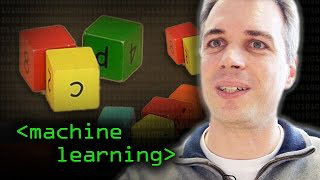

In [13]:
show_info(data_clean, 23)

In [14]:
def show_predictions(data, model):
    video_id = int(input())
    print("ВХОДНЫЕ ДАННЫЕ:")
    show_info(data, video_id)
    print("------------------\n\n")
    print("ПРЕДСКАЗАНИЯ")

    prediction = predict_top3(video_id, data, model)
    for i in range(3):
        show_info(data, list(prediction.index)[i])
        print('\n\n')

78
ВХОДНЫЕ ДАННЫЕ:
Описание фильма с номером 78
Ace your next technical job interview in Python! This quick tutorial goes over the most important questions for web developers to know in preparation tech interviews. 

⭐ Kite is a free AI-powered coding assistant that will help you code faster and smarter. The Kite plugin integrates with all the top editors and IDEs to give you smart completions and documentation while you’re typing. We made this YouTube channel and Kite to help you be more productive:  https://kite.com/download/?utm_medium=referral&utm_source=youtube&utm_campaign=kite&utm_content=5_things_tech_interview
*************************************** 
SUBSCRIBE for more Python tips, tutorials, and project breakdowns! ► https://www.youtube.com/c/KiteHQ?sub_confirmation=1

Follow us Twitter ► https://twitter.com/kitehq

*************************************** 
TIMESTAMPS:

00:17 - object-oriented programming questions 
02:46 - formatting strings for printing
03:51 - leveraging py

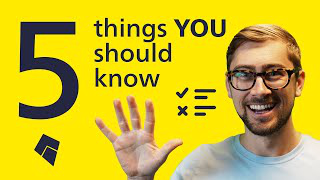

------------------


ПРЕДСКАЗАНИЯ
Описание фильма с номером 80
🔥Intellipaat Python training course: https://intellipaat.com/python-certification-training-online/
This python interview questions and answers will help you ace your next Python Job Interview. We have collected these Python Interview Questions video based on the new curriculum for Python which was recently updated. This Python tutorial has Python interview tips as well so that you can include this in your Python interview preparation and excel in the interview. We have tried to cover almost all the concepts so that you clear the interview with ease.
#PythonInterviewQuestions #PythonInterviewQuestionsandanswers #PythonTutorial #PythonTutorialforBeginners #Intellipaat

📌 Do subscribe to Intellipaat channel & get regular updates on videos: http://bit.ly/Intellipaat

💡 Know top 5 reasons to learn python: https://bit.ly/2IjH1Ng

🔗 Watch complete Python tutorials here: https://www.youtube.com/watch?v=5GYeia8IRbg&list=PLVHgQku8Z93

<ipython-input-6-b4f363494ea5>:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([query_embed.similarity(line) for line in embed_mat])


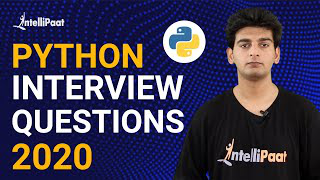




Описание фильма с номером 67
View the Code & GitHub Repository:
https://dcode.domenade.com/tutorials/build-a-single-page-app-with-javascript-no-frameworks

In today's video I'll be showing you how to build a Single Page App using JavaScript without the need for any front-end frameworks. We'll be implementing client-side routing ourselves from the ground up.

This is perfect for any small-to-medium sized website or app.

LINK TO PART 2 📺:
https://youtu.be/OstALBk-jTc

🏷️ THE ULTIMATE JAVASCRIPT DOM CRASH COURSE 👇
https://www.udemy.com/course/the-ultimate-javascript-dom-crash-course/?referralCode=DC343E5C8ED163F337E1

Support me on Patreon:
https://www.patreon.com/dcode - with enough funding I plan to develop a website of some sort with a new developer experience!

Follow me on Twitter @dcodeyt!

If this video helped you out and you'd like to see more, make sure to leave a like and subscribe to dcode!

#dcode #javascript #webapp


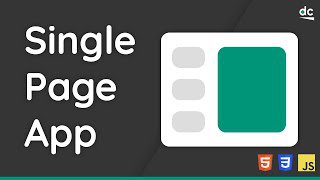




Описание фильма с номером 60
Watch this JavaScript tutorial for beginners to learn JavaScript basics in one hour. 
🔥 Want to master JavaScript? Get my complete JavaScript course: https://bit.ly/3Uod3vF
👍 Subscribe for more tutorials like this: https://goo.gl/6PYaGF

⭐️ Want to learn more from me? Check out these links: 

Courses: https://codewithmosh.com
Twitter: https://twitter.com/moshhamedani
Facebook: https://www.facebook.com/programmingwithmosh/
Blog: http://programmingwithmosh.com 

JavaScript is one of the most popular programming languages in 2022. A lot of people are learning JavaScript to become front-end and/or back-end developers. 

I've designed this JavaScript tutorial for beginners to learn JavaScript from scratch. We'll start off by answering the frequently asked questions by beginners about JavaScript and shortly after we'll set up our development environment and start coding. 

Whether you're a beginner and want to learn to code, or you know any programming languag

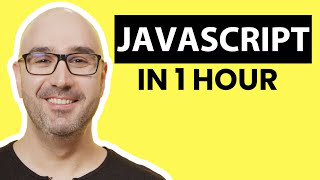

In [15]:
show_predictions(data_clean, nlp)

### Сделаем интерфейс отдельно от ноутбука

In [16]:
!pip install jupyter-dash

In [17]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, State, Output

app = JupyterDash(__name__)

app.layout = html.Div([
    html.Div(dcc.Input(id='input-on-submit', type='text')),
    html.Button('Submit', id='submit-val', n_clicks=0),
    html.Div(id='container-button-basic',
             children='Enter a value and press submit'),
])


@app.callback(
    Output('container-button-basic', 'children'),
    Input('submit-val', 'n_clicks'),
    State('input-on-submit', 'value')
)
def update_output(n_clicks, value):
    prediction = predict_top3(int(value), data_clean, nlp)

    output = []
    for i in range(3):
      output.append('Описание для видео с индексом: ')
      output.append(str(prediction.index[i]))
      output.append(html.Br())
      output.append(prediction.iloc[i]['description'])
      output.append(html.Br())
      output.append(html.Br())
      output.append(html.Br())

    return html.P(output)

app.run_server(host='0.0.0.0')

<ipython-input-17-76bd4c916491>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-17-76bd4c916491>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.
  warnings.warn(


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>